#### Import and loading datasets

In [1]:
!pip install catboost
from catboost import CatBoostClassifier

import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy
%matplotlib inline

from collections import defaultdict
from joblib import dump, load
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import xgboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [2]:
# lOADING DIFFERENT ENCODINGS FOR DIFFERENT MODELS

train_set1 = pd.read_csv('/content/drive/MyDrive/Datasets/Datasets and utils/train_set1.csv')
test_set1 = pd.read_csv('/content/drive/MyDrive/Datasets/Datasets and utils/test_set1.csv')

train_set3 = pd.read_csv('/content/drive/MyDrive/Datasets/Datasets and utils/train_set3.csv')
test_set3 = pd.read_csv('/content/drive/MyDrive/Datasets/Datasets and utils/test_set3.csv')

X_train_cb = pd.read_csv('/content/drive/MyDrive/Datasets/Datasets and utils/X_train_catboost.csv').astype(str)
X_test_cb = pd.read_csv('/content/drive/MyDrive/Datasets/Datasets and utils/X_test_catboost.csv').astype(str)

y_train = pd.read_csv('/content/drive/MyDrive/Datasets/Datasets and utils/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Datasets/Datasets and utils/y_test.csv')

#### Stacker

In [ ]:
# let's append labels to each training feature-set for stacking purposes
train_set1 = pd.concat([train_set1,y_train],axis=1)
train_set3 = pd.concat([train_set3,y_train],axis=1)
X_train_cb = pd.concat([X_train_cb,y_train],axis=1)


class Custom_Stacker:

    def __init__(self,k=8):
        ''' 
        Constructor to initialize a few impt variables
        Architecture of Stacker :- 8(base_models) + Log-Reg(Meta-model)
        All the params taken are the best ones found from previous experimentations
        '''
        self.k = k
        self.best_params = [{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 50},{'n_neighbors': 25}, {'alpha': 100}, {'C': 0.0001,'dual':False},
                            {'n_estimators': 300, 'min_samples_split': 10, 'max_samples': 0.5, 'criterion': 'entropy','random_state':42,'n_jobs' : -1},
                            {'C':1,'random_state':42,'kernel':'rbf','probability':True},
                            {'subsample': 0.7, 'reg_alpha ': 0.05, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7,
                             'random_state':42,'n_jobs':-1},
                            {'min_data_in_leaf': 50, 'depth': 10, 'od_wait': 10, 'l2_leaf_reg': 3, 'iterations': 500, 'subsample': 0.5, 'rsm': 0.3, 'learning_rate': 0.1,
                             'loss_function': 'Logloss','random_state':42,'eval_metric':'F1','custom_metric':'F1','one_hot_max_size':3}
                            ]
        self.base_learners = [DecisionTreeClassifier,KNeighborsClassifier,MultinomialNB,LinearSVC,RandomForestClassifier,SVC,xgboost.XGBClassifier,CatBoostClassifier]
        
        self.trained_base_learners = []

        assert k <= len(self.base_learners),"No. of base-learners can be maximum {}".format(len(self.base_learners))

    def half_split(self,data):
        ''' 
        To make 50-50 splits of data
        '''
        d1 = data[:5074]
        d2 = data[5074:]
        return d1,d2

    def fit(self,train_set1,train_set3,X_train_cb):
        '''
        We have taken 3 feature encoded sets and they are used on their respective models, founded by extensive previous experiments.

        1) take 50-50 splits into D1 & D2
        2) Train base-learners on D1 (Sample with replacement) and make predictions on D2
        3) USE each Base-learner's predictions on D2 with labels as train data for meta-model
        4) TRAIN and store your Meta-model and use it for prediction

        '''
        # 50-50 split train to D1 & D2

        train_set1_d1,train_set1_d2 = self.half_split(train_set1)
        train_set3_d1,train_set3_d2 = self.half_split(train_set3)
        X_train_cb_d1,X_train_cb_d2 = self.half_split(X_train_cb)

        
        # assigning feature-set for each model, according to our observations from the previous experiments
        self.feature_set_d1 = [train_set3_d1,train_set1_d1,train_set1_d1,train_set1_d1,train_set3_d1,train_set1_d1,train_set3_d1,X_train_cb_d1][:self.k]
        self.feature_set_d2 = [train_set3_d2,train_set1_d2,train_set1_d2,train_set1_d2,train_set3_d2,train_set1_d2,train_set3_d2,X_train_cb_d2][:self.k]

        # sample with replacement from D1 to train base-models
        N = X_train_cb_d1.shape[0]
        indices_for_BaseModels = []
        for _ in range(self.k):
            idx = np.random.choice(a=N,size=int(0.7*N),replace=True)
            indices_for_BaseModels.append(idx)

        ## training base models
        if self.trained_base_learners:  # resetting if already trained with the same object before
            self.trained_base_learners = []

        for idx,(data_indices,train,model,params) in enumerate(zip(indices_for_BaseModels,self.feature_set_d1,self.base_learners,self.best_params)):
            y = train.Y.iloc[data_indices].ravel()
            X = train.drop("Y",axis=1).iloc[data_indices,:]
            if idx==7:   # if it's catboost model we have to send one extra parameter
                cat_features = X.columns.values
                model = model(cat_features=cat_features,**params)
            else:
                model = model(**params)
            model.fit(X,y)

            self.trained_base_learners.append(model)   # storing trained base-learners


        # make predictions through each base-learner on D2 and make dataset D3
        M = X_train_cb_d2.shape[0]
        D3 = np.zeros((M,self.k))
        k = 0
        for model,test in zip(self.trained_base_learners,self.feature_set_d2):
            X = test.drop("Y",axis=1)
            D3[:,k] = model.predict(X)
            k += 1

        # making D3 a df
        D3 = np.hstack((D3,X_train_cb_d2.Y.values.reshape(-1,1)))   # appending labels of D2 to prediction of base-models on d2
        self.columns = ['Pred_1','Pred_2','Pred_3','Pred_4','Pred_5','Pred_6','Pred_7','Pred_8'][:self.k]
        self.columns.extend('Y')
        D3 = pd.DataFrame(D3,columns=self.columns) 

        # TRAIN metamodel on D3
        X,y = D3.drop('Y',axis=1),D3.Y.ravel()
        self.MetaModel = LogisticRegression(C=0.001).fit(X,y)
        return 

    def predict(self,test_set1,test_set3,X_test_cb):
        '''
        This function will make predictions on test set for evaluation
        1) Predict the values for test set using your base learners
        2) Then use the ouputs of those base learners as input to meta-model and make final predictions 
        '''
        # we will pass respective feature-encoded test set to each base-learner
        self.feature_set_for_test = [test_set3,test_set1,test_set1,test_set1,test_set3,test_set1,test_set3,X_test_cb][:self.k]

        # storing outputs OF Base-learners in D4
        N = X_test_cb.shape[0]
        D4 = np.zeros((N,self.k))
        k = 0
        for model,data in zip(self.trained_base_learners,self.feature_set_for_test):
            D4[:,k] = model.predict(data)
            k += 1

        # making D4 a df and using it as input for meta-model and returning it's predictions.
        D4 = pd.DataFrame(D4,columns=self.columns[:-1])   # all cols exept 'Y'
        return self.MetaModel.predict(D4)



Let's Evaluate

In [ ]:
results = []
for k in range(8):
    clf = Custom_Stacker(k+1)
    clf.fit(train_set1,train_set3,X_train_cb)
    y_pred = clf.predict(test_set1,test_set3,X_test_cb)
    f1 = metrics.f1_score(y_test,y_pred)
    results.append(f1) 

0:	learn: 0.7511737	total: 25.7ms	remaining: 12.8s
1:	learn: 0.7946627	total: 53.7ms	remaining: 13.4s
2:	learn: 0.8121975	total: 74.5ms	remaining: 12.3s
3:	learn: 0.8248971	total: 101ms	remaining: 12.5s
4:	learn: 0.8377140	total: 126ms	remaining: 12.5s
5:	learn: 0.8502879	total: 147ms	remaining: 12.1s
6:	learn: 0.8677249	total: 171ms	remaining: 12s
7:	learn: 0.8714869	total: 195ms	remaining: 12s
8:	learn: 0.8791156	total: 220ms	remaining: 12s
9:	learn: 0.8809410	total: 249ms	remaining: 12.2s
10:	learn: 0.8795963	total: 269ms	remaining: 12s
11:	learn: 0.8838104	total: 305ms	remaining: 12.4s
12:	learn: 0.8864839	total: 329ms	remaining: 12.3s
13:	learn: 0.8896337	total: 353ms	remaining: 12.3s
14:	learn: 0.8921381	total: 379ms	remaining: 12.3s
15:	learn: 0.9035046	total: 401ms	remaining: 12.1s
16:	learn: 0.9040173	total: 425ms	remaining: 12.1s
17:	learn: 0.9131167	total: 452ms	remaining: 12.1s
18:	learn: 0.9190225	total: 481ms	remaining: 12.2s
19:	learn: 0.9220437	total: 511ms	remaining: 1

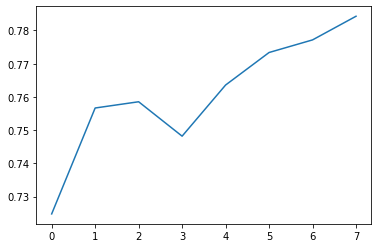

In [ ]:
plt.plot(results)

Obsevation
* Final F1-Score we get from our custom stacker is \~ 0.78 whereas the hper-parameter tuned CatBoost gave the highest F1-Score of \~ 0.80

#### Finally training the Catboost model and saving it for productionization.
Since CatBoost model gave the highest score on metric, we'll use that.

In [4]:
best_params = {'min_data_in_leaf': 50, 'depth': 10, 'od_wait': 10, 'l2_leaf_reg': 3, 'iterations': 500, 'subsample': 0.5, 'rsm': 0.3, 'learning_rate': 0.1,
                             'loss_function': 'Logloss','random_state':42,'eval_metric':'F1','custom_metric':'F1','one_hot_max_size':3}
cat_features = X_train_cb.columns.values
model = CatBoostClassifier(verbose=False,cat_features=cat_features,**best_params)
# training
model.fit(X_train_cb,y_train.values.ravel())
# saving
model.save_model("Final_cb",format="cbm")

### END